# Electricity consumption in buildings prediction using RNN

**Source**: [ASHRAE Kaggle competition](https://www.kaggle.com/c/ashrae-energy-prediction/overview). I use a subset of buildings and timestamps, and limit the data to electricity only.<br><br>
**Data (subset)**: <br>
- time-series of electricity consumption (kWh) in different kinds of buildings (hospitals, residential, industrial, etc.). <br>
- Hourly measurements (noisy!!) lasting for about 4 months.<br><br>

**Problem**: create an RNN model that can predict building's electricity consumption in the next 10 hours<br><br>
**Models used**:<br>
1. RNN with 2 LSTM layers and lagged-time-series feature only (test MSE: 0.1396)<br>
2. 3 LSTM layers + lagged-time-series (MSE: 0.1176)<br>
3. 3 LSTM layers + lagged t-s + time features (week, day, hour...) (MSE: 0.1059)<br>
4. Previous model + L2 regularization (MSE: 0.1143)<br>
5. 3 LSTM layers + all features + time-series deltas (MSE: 0.0767)<br><br>

**Example prediction**: <br>Normalized electricity consumption of a building and Model 4 predicted values.<br>![alt text](https://i.ibb.co/Yf2fzk1/download.png)


# 0. Data download, module import

In [0]:
# keys = eval(open('kaggle.json', 'r').read())

# import os
# os.environ['KAGGLE_USERNAME'] = keys["username"]  
# os.environ['KAGGLE_KEY'] = keys["key"]
# !kaggle competitions download -c ashrae-energy-prediction

In [0]:
# !pip install -q toai 
# !pip install tensorflow-gpu

In [0]:
import tensorflow as tf
from tensorflow import keras
from toai.imports import *
from datetime import datetime

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
DATA_DIR = Path('data/energy')
TEMP_DIR = Path('temp/energy')

DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
!unzip test.csv.zip -d {DATA_DIR}
!unzip train.csv.zip -d {DATA_DIR}
!mv building_metadata.csv {DATA_DIR}

Archive:  test.csv.zip
  inflating: data/energy/test.csv    
Archive:  train.csv.zip
  inflating: data/energy/train.csv   


# 1. Data subsampling, feature engineering

In [0]:
# Load data and parse dates
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

building_train = pd.read_csv(DATA_DIR/'building_metadata.csv')
data_train = pd.read_csv(DATA_DIR/'train.csv', parse_dates=["timestamp"], date_parser=date_parser)

In [0]:
# Check shapes
print(building_train.shape, data_train.shape)

(1449, 6) (20216100, 4)


In [0]:
building_train.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [0]:
building_train.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,6.952381,724.000000,92111.776398,1967.957037,3.740845
std,5.003432,418.434583,110769.950997,31.054030,3.333683
min,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.000000,5.000000
max,15.000000,1448.000000,875000.000000,2017.000000,26.000000


In [0]:
data_train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


### Subsampling
Keep buildings that have the highest number of timepoints. Then filter out the first 4 months of time-series data to keep things manageable.

In [0]:
# Which building id's have > 15000 time measurements
building_counts = data_train.groupby("building_id")["building_id"].count() > 15000
building_train["count"] = building_counts

# Get their ID's
buildings_to_keep = building_train.loc[building_train["count"]==True, 'building_id']
print(buildings_to_keep[:5])

7      7
9      9
13    13
14    14
15    15
Name: building_id, dtype: int64


In [0]:
# Keep a subsample of the train data with building IDs extracted before
data_train_subsample = data_train.loc[data_train["building_id"].isin(buildings_to_keep), :]

# Filter out first 4 months
data_train_subsample = data_train_subsample.loc[(data_train_subsample.timestamp < pd.Timestamp("2016-05-01")) & 
                             (data_train_subsample.timestamp > pd.Timestamp("2016-01-04"))]
data_train_subsample = data_train_subsample.loc[data_train_subsample.meter == 0, :]

In [0]:
# How many cases left
data_train_subsample.shape

(1387813, 4)

In [0]:
# Merge train data with building metadata
data_merged = data_train_subsample.merge(building_train, on="building_id")

In [0]:
data_merged.describe()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count
count,1.387813e+06,1387813.0,1.387813e+06,1.387813e+06,1.387813e+06,383420.000000,103013.000000
mean,8.522010e+02,0.0,2.378235e+02,8.899453e+00,1.275569e+05,1972.065135,6.191840
std,4.302086e+02,0.0,4.925500e+02,4.986930e+00,1.205407e+05,27.832976,5.709875
min,7.000000e+00,0.0,0.000000e+00,0.000000e+00,4.314000e+03,1900.000000,1.000000
25%,2.770000e+02,0.0,4.300000e+01,2.000000e+00,5.255900e+04,1957.000000,2.000000
50%,9.780000e+02,0.0,1.075320e+02,9.000000e+00,9.090300e+04,1970.000000,5.000000
75%,1.209000e+03,0.0,2.406590e+02,1.300000e+01,1.663950e+05,1995.000000,6.000000
max,1.413000e+03,0.0,4.433650e+04,1.500000e+01,8.615240e+05,2016.000000,26.000000


In [0]:
del data_merged["site_id"]
del data_merged["meter"]

In [0]:
# Trim all cases to the same number of time-points

# Check how many time-points per building there are
data_merged.groupby("building_id").count().describe()

# Store the lowest common denominator
lowest_n_timepoints = int(data_merged.groupby("building_id").count().describe().loc["min", "timestamp"])

# For each building, keep the first N number of timestamps
data_merged = (data_merged.sort_values(["building_id", "timestamp"])
                          .groupby("building_id")
                          .head(lowest_n_timepoints))

In [0]:
data_merged = data_merged[["timestamp", "building_id", "consumption_10k_sqft",
                           "primary_use", "month", "week", "day", "hour"]]

### Feature engineering

Consumption is calculated in raw numbers (kWh per hour), while buildings differ a lot in their size. Let's use kWh/1000 sq feet

In [0]:
# Get counts for checks and refs
N_BUILDINGS = data_merged["building_id"].unique().shape[0]
N_TIMESTEPS = data_merged.groupby("building_id").count().iloc[0,0]
N_VARS = data_merged.columns.shape[0]

In [0]:
data_merged["consumption_10k_sqft"] = data_merged["meter_reading"]/data_merged["square_feet"] * 10000

In [0]:
# Extract time 
data_merged["month"] = data_merged.timestamp.map(lambda x: x.month)
data_merged["week"] = data_merged.timestamp.map(lambda x: x.week)
data_merged["day"] = data_merged.timestamp.map(lambda x: x.dayofweek)
data_merged["hour"] = data_merged.timestamp.map(lambda x: x.hour)

# Scale these vars
data_merged.hour /= data_merged.hour.max() 
data_merged.day /= data_merged.day.max()
data_merged.week /= data_merged.week.max()
data_merged.month /= data_merged.month.max()

In [0]:
# Encode timestamps
data_merged["timestamp_id"] = np.tile(np.arange(0, N_TIMESTEPS), N_BUILDINGS)
del data_merged["timestamp"]
data_merged.columns = ['building_id', 'consumption_10k_sqft', 'primary_use', 'month', 'week',
       'day', 'hour', 'timestamp']

In [0]:
# Bulding types to one-hot
data_merged = pd.concat([data_merged, pd.get_dummies(data_merged["primary_use"])], axis=1)

In [0]:
# Calculate means and stds by building id
means = data_merged.groupby("building_id")["consumption_10k_sqft"].mean()
means.name = "mean"
std = data_merged.groupby("building_id")["consumption_10k_sqft"].std()
std.name = "std"
data_merged = data_merged.merge(means, on="building_id")
data_merged = data_merged.merge(std, on="building_id")

# Normalize consumption labels
data_merged["consumption"] = (data_merged["consumption_10k_sqft"] - data_merged["mean"])/data_merged["std"]

In [0]:
# MinMax normalized values
data_merged = data_merged[~data_merged.isna().any(axis=1)]
data_merged = data_merged.loc[data_merged["std"] != 0,:]
data_merged.loc[data_merged["consumption"] < -1, "consumption"] = -1
data_merged.loc[data_merged["consumption"] > 1, "consumption"] = 1

# 2. EDA

The time-series naturally display non-linear time trends at various levels:<br>
- energy consumption fluctuates during the day (peaks @ work hours, decreases at night)<br>
- weekday-weekend differences
- week-by-week differences, possibly related to days off
- energy consumption volume (and trends) vary drastically by building type
- consumption is approx normally distributed, but there are a LOT of 0's, likely due to faulty meter measurements

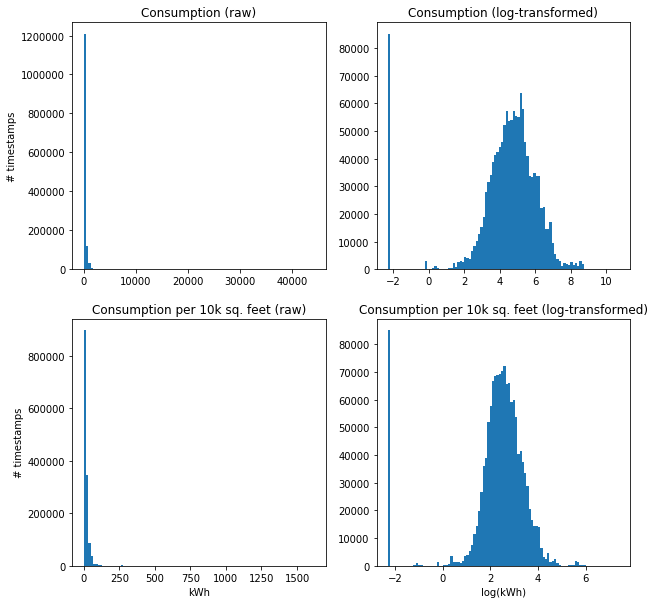

In [0]:
# Consumption distribution
%matplotlib inline
fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax = ax.ravel()
ax[0].hist(data_merged.meter_reading, bins=100)
ax[1].hist(np.log(data_merged.meter_reading + 0.1), bins=100)
ax[2].hist(data_merged.consumption_10k_sqft, bins=100)
ax[3].hist(np.log(data_merged.consumption_10k_sqft + 0.1), bins=100)
ax[0].set_title("Consumption (raw)")
ax[1].set_title("Consumption (log-transformed)")
ax[2].set_title("Consumption per 10k sq. feet (raw)")
ax[3].set_title("Consumption per 10k sq. feet (log-transformed)")
ax[2].set_xlabel("kWh")
ax[3].set_xlabel("log(kWh)")
ax[0].set_ylabel("# timestamps")
ax[2].set_ylabel("# timestamps")
plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


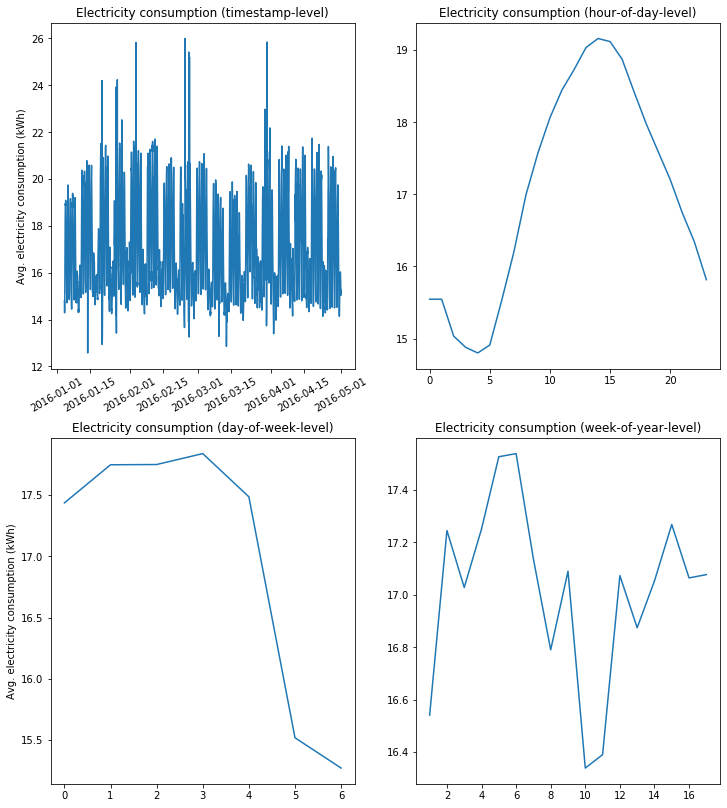

In [0]:
## Plot consumption at different timescales
fig, ax = plt.subplots(2, 2, figsize=(12,14))
ax = ax.ravel()

# Plot total consumption at lowest level
cons_total = data_merged.groupby('timestamp')['consumption_10k_sqft'].mean()
ax[0].plot(cons_total.index, cons_total.values)
ax[0].set_title("Electricity consumption (timestamp-level)")
ax[0].tick_params(axis='x', rotation=30)
ax[0].set_ylabel('Avg. electricity consumption (kWh)')

# Plot hourly consumption
cons_hour = data_merged.groupby('hour')['consumption_10k_sqft'].mean()
ax[1].plot(cons_hour.index, cons_hour.values)
ax[1].set_title("Electricity consumption (hour-of-day-level)")

# Plot daily consumption
cons_day = data_merged.groupby('day')['consumption_10k_sqft'].mean()
ax[2].plot(cons_day.index, cons_day.values)
ax[2].set_title("Electricity consumption (day-of-week-level)")
ax[2].set_ylabel('Avg. electricity consumption (kWh)')

# Plot weekly consumption
cons_week = data_merged.groupby('week')['consumption_10k_sqft'].mean()
ax[3].plot(cons_week.index, cons_week.values)
ax[3].set_title("Electricity consumption (week-of-year-level)")

plt.show()

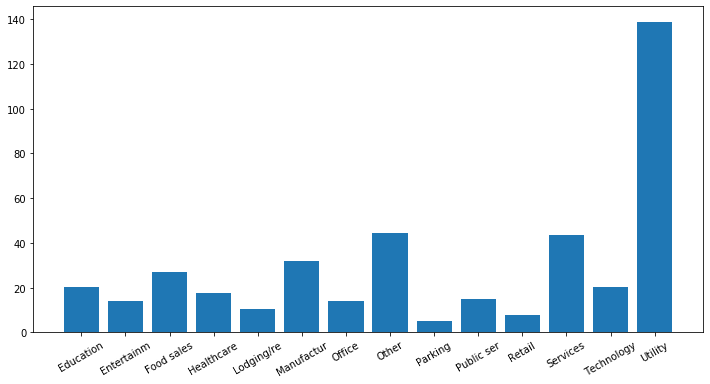

In [0]:
## Consumption by building type
cons_type = data_merged.groupby("primary_use")["consumption_10k_sqft"].mean()
fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.bar(x=cons_type.index.map(lambda x: x[:10]), height=cons_type.values)
ax.tick_params(axis='x', rotation=30)
plt.show()

# 3. Prepare data for modelling

Dataframe -> ndarray -> train/val/test splits<br><br>
I use several sets of train/val/test datasets:<br>
1. Features contain only lagged time-series<br>
2. Features contain lagged time-series + time features (day, hour, week, etc)<br>
3. Full set of features - lagged t-s, time features, building type dummies

In [0]:
# Throw out columns used in EDA, not used in modelling
data_merged = data_merged[data_merged.columns.difference(["consumption_10k_sqft", 
                                                          "primary_use", "mean", "std"])]

In [0]:
data_merged.head()

,Education,Entertainment/public assembly,Food sales and service,Healthcare,Lodging/residential,Manufacturing/industrial,Office,Other,Parking,Public services,Retail,Services,Technology/science,Utility,building_id,consumption,day,hour,month,timestamp,week
3645,1,0,0,0,0,0,0,0,0,0,0,0,0,0,14,-0.028689,0,1,1,0,1
3646,1,0,0,0,0,0,0,0,0,0,0,0,0,0,14,-0.028689,0,2,1,1,1
3647,1,0,0,0,0,0,0,0,0,0,0,0,0,0,14,-0.028689,0,3,1,2,1
3648,1,0,0,0,0,0,0,0,0,0,0,0,0,0,14,-0.028689,0,4,1,3,1
3649,1,0,0,0,0,0,0,0,0,0,0,0,0,0,14,-0.028689,0,5,1,4,1


In [0]:
# Define helper functions
def groupby_to_ndarray(data: pd.DataFrame, groupcol: str) -> np.ndarray:
    return np.array(list(data.groupby(groupcol).apply(np.array)))

def visualize_time_series(array: np.ndarray, id: int, label_var: int) -> None:
    plt.plot(np.arange(array.shape[1]), array[id,:,label_var])

def delete_zero_series(array: np.ndarray, label_var: int) -> np.ndarray:
    new_array = array.copy()
    delete_list = np.array([])
    for i in range(array.shape[0]):
        if np.std(array[i,:,label_var]) < 0.4:
            delete_list = np.append(delete_list, i)
    new_array = np.delete(new_array, delete_list, 0)
    return new_array

def timeseries_extract_distributed_labels(series: np.ndarray, pred_length: int
) -> Tuple[np.ndarray, np.ndarray]:
    n_labels = series.shape[1] - pred_length
    labels = np.empty((series.shape[0], n_labels, pred_length))
    for step_ahead in range(1, pred_length + 1):
        labels[..., step_ahead - 1] = series[..., step_ahead : step_ahead + n_labels, 0]
    return series[:, :-pred_length], labels

In [0]:
# Repeat constants after throwing out some cases
N_BUILDINGS = data_merged["building_id"].unique().shape[0]
N_TIMESTEPS = data_merged.groupby("building_id").count().iloc[0,0]
N_VARS = data_merged.columns.shape[0]

### DF to ndarray

In [0]:
data_array = groupby_to_ndarray(data_merged, "building_id")

In [232]:
# Check shapes and whether dates are still sorted
assert data_array.shape == (N_BUILDINGS, N_TIMESTEPS, N_VARS)
print(f"Shape of ndarray: {data_array.shape}")

Shape of ndarray: (490, 1215, 21)


In [234]:
# Delete zero series
data_array = delete_zero_series(data_array,-6)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  del sys.path[0]


### Visualize several time-series

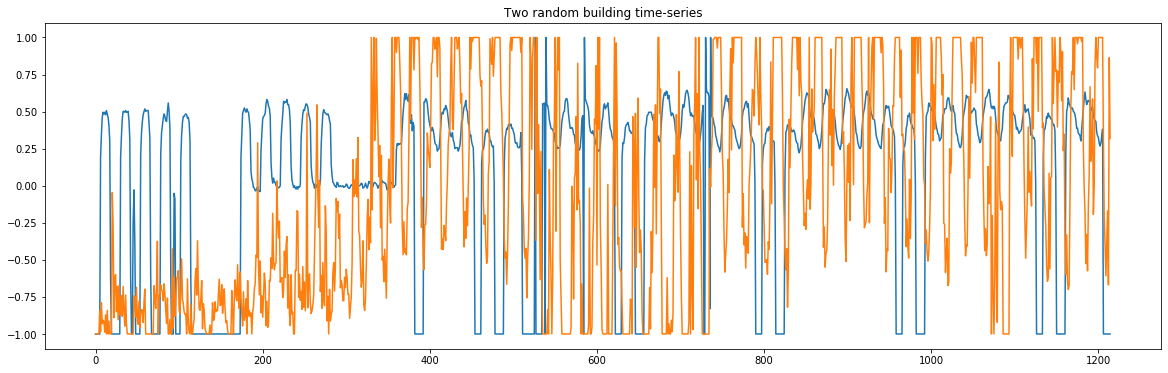

In [235]:
plt.figure(figsize=(20,6))
visualize_time_series(data_array, 200, -6)
visualize_time_series(data_array, 421, -6)
plt.title("Two random building time-series")
plt.show()

### Train/val/test splits for different feature sets

In [236]:
list(enumerate(data_merged.columns))

[(0, 'Education'),
 (1, 'Entertainment/public assembly'),
 (2, 'Food sales and service'),
 (3, 'Healthcare'),
 (4, 'Lodging/residential'),
 (5, 'Manufacturing/industrial'),
 (6, 'Office'),
 (7, 'Other'),
 (8, 'Parking'),
 (9, 'Public services'),
 (10, 'Retail'),
 (11, 'Services'),
 (12, 'Technology/science'),
 (13, 'Utility'),
 (14, 'building_id'),
 (15, 'consumption'),
 (16, 'day'),
 (17, 'hour'),
 (18, 'month'),
 (19, 'timestamp'),
 (20, 'week')]

In [0]:
## Feature/label split of full data
labels = data_array[:,:,-6]
labels = np.expand_dims(labels, 2)

features = np.delete(data_array, [14, 19], axis=2)

In [251]:
print(features.shape, labels.shape)

(470, 1215, 19) (470, 1215, 1)


In [0]:
## Extract +10 steps in labels
labels_10 = timeseries_extract_distributed_labels(labels, pred_length=10)[1]

In [253]:
print("Label for the first timepoint:\n", labels_10[21, 0, :], "\nFeature:\n", data_array[21, :10, -6])

Label for the first timepoint:
 [-0.00998996  0.16854466  0.046546   -0.23953447 -0.17619719 -0.27906713
 -0.54474365 -0.31519914 -0.06525068  0.21020273] 
Feature:
 [ 0.10733279 -0.00998996  0.16854466  0.046546   -0.23953447 -0.17619719
 -0.27906713 -0.54474365 -0.31519914 -0.06525068]


In [332]:
# Shuffle buildings
shuffled_ids = np.random.randint(0, 470, 470)

# Split into train/val/test
(train_features, train_labels) = (features[shuffled_ids[:300], :1205, :], labels_10[shuffled_ids[:300], :, :])
(val_features, val_labels) = (features[shuffled_ids[300:385], :1205, :], labels_10[shuffled_ids[300:385], :, :])
(test_features, test_labels) = (features[shuffled_ids[385:], :1205, :], labels_10[shuffled_ids[385:], :, :])

print(f"Feature shapes (tr/va/te): {train_features.shape}, {val_features.shape}, {test_features.shape}")
print(f"Label shapes (tr/va/te): {train_labels.shape}, {val_labels.shape}, {test_labels.shape}")

Feature shapes (tr/va/te): (300, 1205, 19), (85, 1205, 19), (85, 1205, 19)
Label shapes (tr/va/te): (300, 1205, 10), (85, 1205, 10), (85, 1205, 10)


In [0]:
# Make a version with no features (time-series only)
(train_features_tsonly, val_features_tsonly, test_features_tsonly) = (train_features[:, :, -5], 
                                                                      val_features[:, :, -5], 
                                                                      test_features[:, :, -5],
                                                                      )
(train_features_tsonly, val_features_tsonly, test_features_tsonly) = (np.expand_dims(train_features_tsonly, 2),
                                                                      np.expand_dims(val_features_tsonly, 2),
                                                                      np.expand_dims(test_features_tsonly, 2),
                                                                      )

# Make a version with time-series and time features (day, hour, week, etc)
(train_features_tsplus, val_features_tsplus, test_features_tsplus) = (train_features[:, :, -5:], 
                                                                      val_features[:, :, -5:], 
                                                                      test_features[:, :, -5:],
                                                                      )

In [273]:
print(f"Check if we extracted labels: {train_features_tsonly[0,:,:].mean()}")
print(f"Check if we extracted time features: {train_features_tsplus[0,0,:]}")
print(f"Check shapes: {train_features_tsonly.shape}, {train_features_tsplus.shape}")

Check if we extracted labels: -0.11031775847972491
Check if we extracted time features: [0.08224052 0.         0.04347826 1.         1.        ]
Check shapes: (300, 1205, 1), (300, 1205, 5)


# 4. Modelling

5 different models, all trained for 100 epochs with fixed LR to make things feasible and comparable:<br>
1. Neural net with 2 LSTM layers and lagged-time-series feature only.<br>
2. 3 LSTM layers + lagged-time-series<br>
3. 3 LSTM layers + lagged t-s + time features (week, day, hour...)<br>
4. Previous model + L2 regularization
5. 3 LSTM layers + all features + time-series deltas

In [274]:
# Build the first model - 2 lstm layers
model_2lstm_nofeatures = keras.models.Sequential(
    [
        keras.layers.LSTM(256, dropout=0.1, return_sequences=True, input_shape=[None, 1]),
        keras.layers.LSTM(128, dropout=0.1, return_sequences=True),
        keras.layers.Dense(10),
    ]
)

# Compile
model_2lstm_nofeatures.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(lr=8e-4))

# Save weights + reduce lr callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(str(DATA_DIR)+"/model_2lstm_nofeatures.h5", save_best_only=True, save_weights_only=True),
    keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.3, min_lr=3e-5),
]

# Fit
model_2lstm_nofeatures.fit(
    train_features_tsonly,
    train_labels,
    validation_data=(val_features_tsonly, val_labels),
    epochs=100,
    verbose=2,
    callbacks=callbacks,
)

# Load best weights
model_2lstm_nofeatures.load_weights(str(DATA_DIR)+"/model_2lstm_nofeatures.h5")

Train on 300 samples, validate on 85 samples
Epoch 1/100
300/300 - 11s - loss: 0.4694 - val_loss: 0.3522
Epoch 2/100
300/300 - 5s - loss: 0.3066 - val_loss: 0.2927
Epoch 3/100
300/300 - 5s - loss: 0.2709 - val_loss: 0.2594
Epoch 4/100
300/300 - 5s - loss: 0.2424 - val_loss: 0.2407
Epoch 5/100
300/300 - 5s - loss: 0.2268 - val_loss: 0.2323
Epoch 6/100
300/300 - 5s - loss: 0.2273 - val_loss: 0.2298
Epoch 7/100
300/300 - 5s - loss: 0.2117 - val_loss: 0.2174
Epoch 8/100
300/300 - 5s - loss: 0.2028 - val_loss: 0.2110
Epoch 9/100
300/300 - 5s - loss: 0.1968 - val_loss: 0.2087
Epoch 10/100
300/300 - 5s - loss: 0.1953 - val_loss: 0.2182
Epoch 11/100
300/300 - 5s - loss: 0.1974 - val_loss: 0.2078
Epoch 12/100
300/300 - 5s - loss: 0.1897 - val_loss: 0.2021
Epoch 13/100
300/300 - 5s - loss: 0.1852 - val_loss: 0.1998
Epoch 14/100
300/300 - 5s - loss: 0.1813 - val_loss: 0.2007
Epoch 15/100
300/300 - 5s - loss: 0.1798 - val_loss: 0.1966
Epoch 16/100
300/300 - 5s - loss: 0.1791 - val_loss: 0.1955
Epo

In [275]:
# Same sequence with 3 LSTM layers
model_3lstm_nofeatures = keras.models.Sequential(
    [
        keras.layers.LSTM(512, dropout=0.1, return_sequences=True, input_shape=[None, 1]),
        keras.layers.LSTM(256, dropout=0.1, return_sequences=True),
        keras.layers.LSTM(128, dropout=0.1, return_sequences=True),
        keras.layers.Dense(10),
    ]
)

# Compile
model_3lstm_nofeatures.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(lr=8e-4))

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(str(DATA_DIR)+"/model_3lstm_nofeatures.h5", save_best_only=True, save_weights_only=True),
    keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.3, min_lr=3e-5),
]

# Fit
model_3lstm_nofeatures.fit(
    train_features_tsonly,
    train_labels,
    validation_data=(val_features_tsonly, val_labels),
    epochs=100,
    verbose=2,
    callbacks=callbacks,
)

# Load weights
model_3lstm_nofeatures.load_weights(str(DATA_DIR)+"/model_3lstm_nofeatures.h5")

Train on 300 samples, validate on 85 samples
Epoch 1/100
300/300 - 15s - loss: 0.4425 - val_loss: 0.3236
Epoch 2/100
300/300 - 10s - loss: 0.3028 - val_loss: 0.2910
Epoch 3/100
300/300 - 10s - loss: 0.2704 - val_loss: 0.2624
Epoch 4/100
300/300 - 10s - loss: 0.2467 - val_loss: 0.2449
Epoch 5/100
300/300 - 10s - loss: 0.2325 - val_loss: 0.2311
Epoch 6/100
300/300 - 10s - loss: 0.2206 - val_loss: 0.2231
Epoch 7/100
300/300 - 10s - loss: 0.2119 - val_loss: 0.2402
Epoch 8/100
300/300 - 10s - loss: 0.2172 - val_loss: 0.2254
Epoch 9/100
300/300 - 10s - loss: 0.2039 - val_loss: 0.2102
Epoch 10/100
300/300 - 10s - loss: 0.1931 - val_loss: 0.2091
Epoch 11/100
300/300 - 10s - loss: 0.1866 - val_loss: 0.2029
Epoch 12/100
300/300 - 10s - loss: 0.1928 - val_loss: 0.2052
Epoch 13/100
300/300 - 10s - loss: 0.1860 - val_loss: 0.1949
Epoch 14/100
300/300 - 10s - loss: 0.1824 - val_loss: 0.2044
Epoch 15/100
300/300 - 10s - loss: 0.1873 - val_loss: 0.2064
Epoch 16/100
300/300 - 10s - loss: 0.1865 - val_l

In [276]:
# Same model, but mind the train/val datasets - different feature sets
model_3lstm_half_feat = keras.models.Sequential(
    [
        keras.layers.LSTM(512, dropout=0.1, return_sequences=True, input_shape=[None, 5]),
        keras.layers.LSTM(256, dropout=0.1, return_sequences=True),
        keras.layers.LSTM(128, dropout=0.1, return_sequences=True),
        keras.layers.Dense(10),
    ]
)

# Compile
model_3lstm_half_feat.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(lr=8e-4))

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(str(DATA_DIR)+"/model_3lstm_half_feat.h5", save_best_only=True, save_weights_only=True),
    keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.3, min_lr=3e-5),
]

# Train (new features used here)
model_3lstm_half_feat.fit(
    train_features_tsplus,
    train_labels,
    validation_data=(val_features_tsplus, val_labels),
    epochs=100,
    verbose=2,
    callbacks=callbacks,
)

# Load best weights
model_3lstm_half_feat.load_weights(str(DATA_DIR)+"/model_3lstm_half_feat.h5")

Train on 300 samples, validate on 85 samples
Epoch 1/100
300/300 - 15s - loss: 0.5335 - val_loss: 0.4899
Epoch 2/100
300/300 - 10s - loss: 0.4285 - val_loss: 0.3231
Epoch 3/100
300/300 - 10s - loss: 0.2779 - val_loss: 0.2622
Epoch 4/100
300/300 - 10s - loss: 0.2445 - val_loss: 0.2372
Epoch 5/100
300/300 - 10s - loss: 0.2269 - val_loss: 0.2247
Epoch 6/100
300/300 - 10s - loss: 0.2157 - val_loss: 0.2193
Epoch 7/100
300/300 - 10s - loss: 0.2057 - val_loss: 0.2063
Epoch 8/100
300/300 - 10s - loss: 0.1969 - val_loss: 0.2199
Epoch 9/100
300/300 - 10s - loss: 0.1998 - val_loss: 0.2039
Epoch 10/100
300/300 - 10s - loss: 0.1846 - val_loss: 0.1887
Epoch 11/100
300/300 - 10s - loss: 0.1739 - val_loss: 0.1903
Epoch 12/100
300/300 - 10s - loss: 0.1798 - val_loss: 0.1955
Epoch 13/100
300/300 - 10s - loss: 0.1734 - val_loss: 0.1823
Epoch 14/100
300/300 - 10s - loss: 0.1681 - val_loss: 0.1778
Epoch 15/100
300/300 - 10s - loss: 0.1625 - val_loss: 0.1862
Epoch 16/100
300/300 - 10s - loss: 0.1653 - val_l

In [279]:
# Let's add some regularization
model_3lstm_half_feat_reg = keras.models.Sequential(
    [
        keras.layers.LSTM(512, dropout=0.1, return_sequences=True, 
                          kernel_regularizer=keras.regularizers.L1L2(1e-8,5e-4),
                          input_shape=[None, 5]),
        keras.layers.LSTM(256, dropout=0.1, kernel_regularizer=keras.regularizers.L1L2(1e-8,5e-4),
                          return_sequences=True),
        keras.layers.LSTM(128, dropout=0.1, return_sequences=True),
        keras.layers.Dense(10),
    ]
)

model_3lstm_half_feat_reg.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(lr=8e-4))

callbacks = [
    keras.callbacks.ModelCheckpoint(str(DATA_DIR)+"/model_3lstm_half_feat_reg.h5", save_best_only=True, save_weights_only=True),
    keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.3, min_lr=3e-5),
]

model_3lstm_half_feat_reg.fit(
    train_features_tsplus,
    train_labels,
    validation_data=(val_features_tsplus, val_labels),
    epochs=100,
    verbose=2,
    callbacks=callbacks,
)
model_3lstm_half_feat_reg.load_weights(str(DATA_DIR)+"/model_3lstm_half_feat_reg.h5")

Train on 300 samples, validate on 85 samples
Epoch 1/100
300/300 - 16s - loss: 0.8607 - val_loss: 0.7707
Epoch 2/100
300/300 - 10s - loss: 0.6865 - val_loss: 0.5465
Epoch 3/100
300/300 - 10s - loss: 0.4982 - val_loss: 0.4647
Epoch 4/100
300/300 - 10s - loss: 0.4267 - val_loss: 0.4037
Epoch 5/100
300/300 - 10s - loss: 0.3805 - val_loss: 0.3620
Epoch 6/100
300/300 - 10s - loss: 0.3448 - val_loss: 0.3323
Epoch 7/100
300/300 - 10s - loss: 0.3190 - val_loss: 0.3095
Epoch 8/100
300/300 - 10s - loss: 0.2949 - val_loss: 0.3062
Epoch 9/100
300/300 - 10s - loss: 0.2827 - val_loss: 0.2763
Epoch 10/100
300/300 - 10s - loss: 0.2634 - val_loss: 0.2643
Epoch 11/100
300/300 - 10s - loss: 0.2505 - val_loss: 0.2592
Epoch 12/100
300/300 - 10s - loss: 0.2456 - val_loss: 0.2491
Epoch 13/100
300/300 - 10s - loss: 0.2334 - val_loss: 0.2390
Epoch 14/100
300/300 - 10s - loss: 0.2236 - val_loss: 0.2319
Epoch 15/100
300/300 - 10s - loss: 0.2232 - val_loss: 0.2321
Epoch 16/100
300/300 - 10s - loss: 0.2133 - val_l

### Define time-series deltas
One thing that helps a lot in classical time-series modelling is modelling deltas (label_value_today - label_value_yesterday) instead of raw values. Let's try that here with the labels.

In [0]:
# Define ts to delta ts converter
def ts_to_delta_ts(array: np.ndarray):
    new_array = array.copy()
    new_array[:,0] = 0
    for i in range(1, array.shape[1]):
        new_array[:,i] = array[:,i] - array[:,i-1]
    return new_array

In [0]:
# Convert time-series consumption columns (in features and labels) in 
# train/val/test sets with all features
train_features_delta = train_features.copy()
train_features_delta[:,:,14] = ts_to_delta_ts(train_features_delta[:,:,14])
train_labels_delta = ts_to_delta_ts(train_labels)

val_features_delta = val_features.copy()
val_features_delta[:,:,14] = ts_to_delta_ts(val_features_delta[:,:,14])
val_labels_delta = ts_to_delta_ts(val_labels)

test_features_delta = test_features.copy()
test_features_delta[:,:,14] = ts_to_delta_ts(test_features_delta[:,:,14])
test_labels_delta = ts_to_delta_ts(test_labels)

In [335]:
print(f"Building 1, timepoint 1 consumption: {train_features_delta[0, 0, 14]},\n" 
      f"Building 1, timepoint 1 labels: {train_labels_delta[0,1]}")

Building 1, timepoint 1 consumption: 0.0,
Building 1, timepoint 1 labels: [-0.18566824  0.74267294 -0.42438454 -0.3978605   0.84876908 -0.50395664
  0.10609613  0.79572101 -0.55700471  0.        ]


In [314]:
# Create a model and use that data
model_3lstm_feat = keras.models.Sequential(
    [
        keras.layers.LSTM(512, dropout=0.1, return_sequences=True, input_shape=[None, 19]),
        keras.layers.LSTM(256, dropout=0.1, return_sequences=True),
        keras.layers.LSTM(128, dropout=0.1, return_sequences=True),
        keras.layers.Dense(10),
    ]
)

model_3lstm_feat.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(lr=8e-4))

callbacks = [
    keras.callbacks.ModelCheckpoint(str(DATA_DIR)+"/model_3lstm_feat.h5", save_best_only=True, save_weights_only=True),
    keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.3, min_lr=3e-5),
]

model_3lstm_feat.fit(
    train_features_delta,
    train_labels_delta,
    validation_data=(val_features_delta, val_labels_delta),
    epochs=100,
    verbose=2,
    callbacks=callbacks,
)
model_3lstm_feat.load_weights(str(DATA_DIR)+"/model_3lstm_feat_reg.h5")

Train on 300 samples, validate on 85 samples
Epoch 1/100
300/300 - 15s - loss: 0.1427 - val_loss: 0.1093
Epoch 2/100
300/300 - 10s - loss: 0.1087 - val_loss: 0.1064
Epoch 3/100
300/300 - 10s - loss: 0.1067 - val_loss: 0.1046
Epoch 4/100
300/300 - 10s - loss: 0.1054 - val_loss: 0.1028
Epoch 5/100
300/300 - 10s - loss: 0.1033 - val_loss: 0.0991
Epoch 6/100
300/300 - 10s - loss: 0.1007 - val_loss: 0.0951
Epoch 7/100
300/300 - 10s - loss: 0.0962 - val_loss: 0.0907
Epoch 8/100
300/300 - 10s - loss: 0.0939 - val_loss: 0.0900
Epoch 9/100
300/300 - 10s - loss: 0.0929 - val_loss: 0.0892
Epoch 10/100
300/300 - 10s - loss: 0.0923 - val_loss: 0.0889
Epoch 11/100
300/300 - 10s - loss: 0.0919 - val_loss: 0.0886
Epoch 12/100
300/300 - 10s - loss: 0.0915 - val_loss: 0.0884
Epoch 13/100
300/300 - 10s - loss: 0.0912 - val_loss: 0.0882
Epoch 14/100
300/300 - 10s - loss: 0.0910 - val_loss: 0.0881
Epoch 15/100
300/300 - 10s - loss: 0.0908 - val_loss: 0.0880
Epoch 16/100
300/300 - 10s - loss: 0.0908 - val_l

# 5. Evaluate and visualize results

### Evaluate

In [356]:
m1_loss = model_2lstm_nofeatures.evaluate(test_features_tsonly, test_labels)
m2_loss = model_3lstm_nofeatures.evaluate(test_features_tsonly, test_labels)
m3_loss = model_3lstm_half_feat.evaluate(test_features_tsplus, test_labels)
m4_loss = model_3lstm_half_feat_reg.evaluate(test_features_tsplus, test_labels)
m5_loss = model_3lstm_feat_reg.evaluate(test_features_delta, test_labels_delta)

85/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

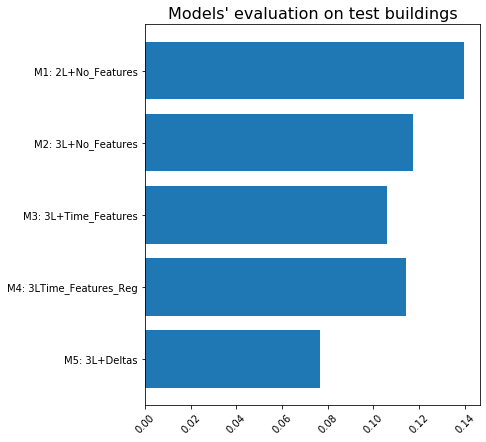

In [375]:
# Plot test losses
plt.figure(figsize=(6,7))
plt.barh(y=["M1: 2L+No_Features", "M2: 3L+No_Features", "M3: 3L+Time_Features", 
            "M4: 3LTime_Features_Reg", "M5: 3L+Deltas"][::-1], 
         width=[m1_loss, m2_loss, m3_loss, m4_loss, m5_loss][::-1])
plt.xticks(rotation=45)
plt.title("Models' evaluation on test buildings", fontsize=16)
plt.show()

### Visualize

In [0]:
# Define helper functions for plotting (Thanks to mokahaiku @github)
def plot_timeseries(
    series: np.ndarray,
    n_steps: int,
    y_true: Optional[float] = None,
    y_pred: Optional[float] = None,
):
    plt.plot(series, ".-")
    if y_true is not None:
        plt.plot(n_steps, y_true, "bo", markersize=8)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro", markersize=8)

def plot_multiple_distributed_forecasts(data, labels, predictions, id):
    n_steps = data.shape[1]
    ahead = labels.shape[2]
    plot_timeseries(data[id, -ahead * 2 :, 0], ahead * 2)
    plt.plot(
        np.arange(ahead * 2, ahead * 3),
        labels[id, n_steps - 1, :],
        "ro-",
        label="Actual",
        markersize=5,
    )
    plt.plot(
        np.arange(ahead * 2, ahead * 3),
        predictions[id, n_steps - 1, :],
        "go-",
        label="Forecast",
        markersize=5,
    )

    plt.legend(fontsize=14)

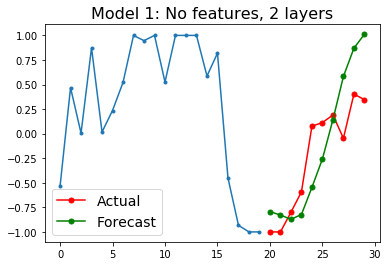

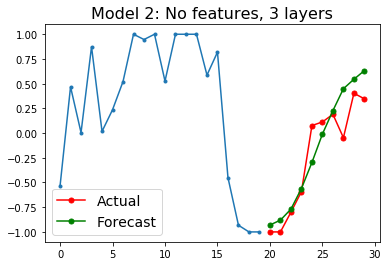

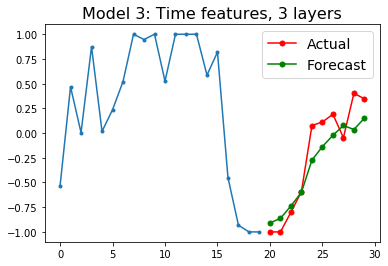

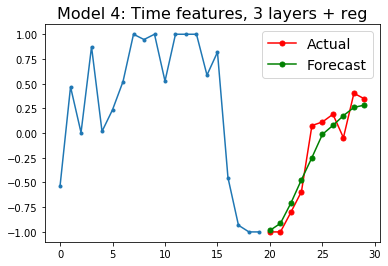

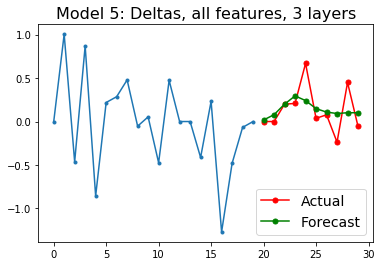

In [406]:
# Model 1 fig
m1_preds = model_2lstm_nofeatures.predict(train_features_tsonly)
fig1 = plt.figure()
plt.title("Model 1: No features, 2 layers", fontsize=16)
fig1 = plot_multiple_distributed_forecasts(train_labels, train_labels, m1_preds, 6)
# Model 2 fig
m2_preds = model_3lstm_nofeatures.predict(train_features_tsonly)
fig2 = plt.figure()
plt.title("Model 2: No features, 3 layers", fontsize=16)
fig2 = plot_multiple_distributed_forecasts(train_labels, train_labels, m2_preds, 6)
# Model 3 fig
m3_preds = model_3lstm_half_feat.predict(train_features_tsplus)
fig3 = plt.figure()
plt.title("Model 3: Time features, 3 layers", fontsize=16)
fig3 = plot_multiple_distributed_forecasts(train_labels, train_labels, m3_preds, 6)
# Model 4 fig
m4_preds = model_3lstm_half_feat_reg.predict(train_features_tsplus)
fig4 = plt.figure()
plt.title("Model 4: Time features, 3 layers + reg", fontsize=16)
fig4 = plot_multiple_distributed_forecasts(train_labels, train_labels, m4_preds, 6)
# Model 5 fig
m5_preds = model_3lstm_feat_reg.predict(train_features_delta)
fig5 = plt.figure()
plt.title("Model 5: Deltas, all features, 3 layers", fontsize=16)
fig5 = plot_multiple_distributed_forecasts(train_labels_delta, train_labels_delta, m5_preds, 6)